# CNN 과제 - 꽃 이미지 분류하기

---
### 과제목표

+ 5가지 꽃 품종을 분류하는 CNN 모델 만들기
---
### 과제내용

+ CNN 이론을 이해하고 Tensorflow로 구현함으로써, CNN의 동작 과정을 이해
+ 세부적으로는 주어진 사진 데이터셋을 가지고 5가지 꽃의 품종을 분류하는 CNN 모델을 학습

---
### 필요 라이브러리
+ tensorflow 1.15, tqdm, numpy, matplotlib, tensorflow-datasets 1.2.0

---
### 데이터셋 구성

+ 학습시간을 위해 64x64 크기로 사전에 전처리
+ 학습(Training) 데이터 : 꽃 이미지 2220장
+ 검증(Validation) 데이터 : 꽃 이미지 730장
+ 테스트(Test) 데이터 : 꽃 이미지 720장

---
### 평가방법

+ 테스트 데이터 720장으로 정답률 비교

&#62;&#62; 테스트 데이터 정답률이 높을수록 점수 획득.

---
### 코드작성방법

#### 코드작성 셀(수정가능) 작성가이드
>  __수정 가능 셀은 자유롭게 변경가능. <font color=red> 단, 반드시 수정 불가 셀의 코드를 고려하여 변경.__</font>
+ dropout_rate 변수
    + 드롭아웃 비율 지정하는 변수. 조정 가능.
+ train_epoch 변수
    - 학습할 epoch 횟수 지정. 조정 가능
+ build_CNN_classifier(x) 함수
    - 신경망 구성하는 함수. CNN 기반으로 자유롭게 재구성 가능.
    
### 실습 전 설치해야 할 것
+ conda install tqdm
+ conda install tensorflow-datasets==1.2.0

### 코드실행 셀<font color=red>(수정불가)</font>
+ 데이터 전처리 및 배치 사이즈 함수 정의

In [1]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1


In [2]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 37kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 512kB 59.3MB/s 
     |████████████████████████████████| 3.8MB 53.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d3ba12d108f04838b405f74954ce8fc63d3028bcc85e0b1a3c4ad82192e63d28
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [3]:
!pip install tensorflow-datasets==1.2.0

     |████████████████████████████████| 2.3MB 6.7MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [13]:
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

tf.reset_default_graph()
tf.compat.v1.disable_eager_execution()

#-----------------------데이터 셋을 가져와 Train_datast, Validation_dataset, Test_dataset 분리
def data():
    train_dataset, validation_dataset, test_dataset=tfds.load(name='tf_flowers', split=[tfds.Split.TRAIN.subsplit(tfds.percent[:60]),
                                                                tfds.Split.TRAIN.subsplit(tfds.percent[60:80]),    
                                                                tfds.Split.TRAIN.subsplit(tfds.percent[80:])
                                                                ],shuffle_files=False)
    return train_dataset, validation_dataset, test_dataset

#-----------------------전처리 함수 정의
def preprocess():
    train_dataset, validation_dataset, test_dataset =data()
    
    #-----------------------Train Data 전처리
    train_image_array=[]
    train_label_array=[]
    train_size=0
    for train_data in tfds.as_numpy(train_dataset):
        train_image_data=train_data['image']
        train_image_array.append(train_image_data)
        train_label_data=train_data['label']
        train_label_array.append(train_label_data)
        train_size+=1   
    for i in range(train_size):
        train_image_array[i]=cv2.resize(train_image_array[i], (64, 64))/255
        
# -----------------------Validation Data전처리    
    validation_image_array=[]
    validation_label_array=[]
    validation_size=0
    for validation_data in tfds.as_numpy(validation_dataset):
        validation_image_data=validation_data['image']
        validation_image_array.append(validation_image_data)
        validation_label_data=validation_data['label']
        validation_label_array.append(validation_label_data)
        validation_size+=1

    for i in range(validation_size):
        validation_image_array[i]=cv2.resize(validation_image_array[i], (64, 64))/255    

# -----------------------Test Data전처리    
    test_image_array=[]
    test_label_array=[]
    test_size=0
    for test_data in tfds.as_numpy(test_dataset):
        test_image_data=test_data['image']
        test_image_array.append(test_image_data)
        test_label_data=test_data['label']
        test_label_array.append(test_label_data)
        test_size+=1

    for i in range(test_size):
        test_image_array[i]=cv2.resize(test_image_array[i], (64, 64))/255    
        
    return train_image_array, train_label_array, validation_image_array, validation_label_array, test_image_array, test_label_array

#-----------------------배치함수 정의
def next_batch(num, data, labels):
    idx=np.arange(0, len(data))
    np.random.shuffle(idx)
    idx=idx[:num]
    data_shuffle=[data[i] for i in idx]
    labels_shuffle=[labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### 코드실행 셀<font color=red>(수정불가)</font>
+ 시각화 함수 정의

In [17]:
#-----------------------시각화 함수 정의
def visualization():    
    print("\n=================================")
    print("        Student Info")
    print("=================================")
    print("이름 : ", student_name)

    print("\n=================================")
    print("        Dataset Info")
    print("=================================")
    print("- 총 3670개의 꽃 이미지 학습 데이터로 구성")

    fig=plt.figure(figsize=(10, 4))

    for i in range(10):
        ax=fig.add_subplot(2, 5, i+1)
        image_show=batch[0]
        label_show=batch[1]
        plt.imshow(image_show[i])
        ax.set_xlabel(label_show[i])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        if i == 2:
            ax.set_title("Dataset example", fontsize=18)

    plt.show()
    print("0:Dandelion 1:Daisy 2:Tulips 3:Sunflowers 4:Roses")

    print("\n=================================")
    print("        Train Info")
    print("=================================")
    print("학습시간 : {}초".format(round(train_time, 3)))
    print("학습 epoch : ", train_epoch)
    print("dropout rate : ", dropout_rate)

    print("\n=================================")
    print("           Train Loss")
    print("=================================")
    for i in range(len(plt_index)-1):
        print("epoch : {}\tloss : {}".format(plt_index[i+1], round(plt_train_loss[i+1], 5)))

    plt.title("Train loss", fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    if train_epoch >= 10:
        plt.xticks([i for i in range(0, plt_index[-1]+1, int(plt_index[-1]/5))])

    plt.plot(plt_index, plt_train_loss, '-')
    plt.show()

    print("\n=================================")
    print("           Train Accuracy")
    print("=================================")
    for i in range(len(plt_index)-1):
        print("epoch : {}\taccuracy : {}%".format(plt_index[i+1], round(plt_train_accuracy[i+1]*100, 5)))

    plt.title("Train Accuracy", fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.plot(plt_index, plt_train_accuracy, "g")
    if train_epoch >= 10:
        plt.xticks([i for i in range(0, plt_index[-1]+1, int(plt_index[-1]/5))])

    plt.show()

    print("\n=================================")
    print("              Validation")
    print("=================================")

    print("Validation Loss : {}".format(round(validation_loss, 5)))
    print("Validation Accuracy : {}%".format(round(validation_accuracy*100, 5)))

    plt.suptitle('Validation Result',fontsize=14)
    plt.subplot(121)
    plt.bar([0, 1, 2], [0, validation_loss, 0], color="orange")
    plt.xticks([1],["Validation Loss"])

    plt.subplot(122)
    plt.bar([0, 1, 2], [0, validation_accuracy, 0], color="blue")
    plt.xticks([1],["Validation Accuracy"])
    plt.show()

    print("\n=================================")
    print("              test")
    print("=================================")

    print("test Loss : {}".format(round(test_loss, 5)))
    print("test Accuracy : {}%".format(round(test_accuracy*100, 5)))

    plt.suptitle('Validation Result',fontsize=14)
    plt.subplot(121)
    plt.bar([0, 1, 2], [0, test_loss, 0], color="orange")
    plt.xticks([1],["test Loss"])

    plt.subplot(122)
    plt.bar([0, 1, 2], [0, test_accuracy, 0], color="blue")
    plt.xticks([1],["test Accuracy"])
    plt.show()

### 코드작성 셀<font color=blue>(수정가능)</font>
+ CNN 모델링

In [20]:
student_name="김민규" #자신의 학번과 이름으로 수정
dropout_rate = 0.3 #드롭아웃 비율 설정
train_epoch=2000 #에폭 설정

def build_CNN_classifier(x):
    # 입력 이미지
    x_image=x

    # 첫번째 convolutional layer
    W_conv1=tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 64], stddev=5e-2))
    b_conv1=tf.Variable(tf.constant(0.1, shape=[64]))
    h_conv1=tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')+b_conv1)

    # 첫번째 Pooling layer
    h_pool1=tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # 두번째 Pooling layer
    h_pool2=tf.nn.max_pool(h_pool1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')

    # 두번째 convolutional layer
    W_conv2=tf.Variable(tf.truncated_normal(shape=[5, 5, 64, 64], stddev=5e-2))
    b_conv2=tf.Variable(tf.constant(0.1, shape=[64]))  
    h_conv2=tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+b_conv2)

    # 세번째 Pooling layer
    h_pool3=tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    

    # 첫번째 Fully Connected Layer 
    W_fc1=tf.Variable(tf.truncated_normal(shape=[16*16*64, 256], stddev=5e-2))
    b_fc1=tf.Variable(tf.constant(0.1, shape=[256]))   
    h_pool3_flat=tf.reshape(h_pool3, [-1, 16*16*64])
    h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1)+b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob = 0.5) 

    # 두번째 Fully Connected Layer 
    W_fc2=tf.Variable(tf.truncated_normal(shape=[256, 5], stddev=5e-2))
    b_fc2=tf.Variable(tf.constant(0.1, shape=[5]))    
    logits=tf.matmul(h_fc1_drop, W_fc2)+b_fc2
    y_pred=tf.nn.softmax(logits)

    return y_pred, logits

x=tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
y=tf.placeholder(tf.int64, shape=[None])
keep_prob=tf.placeholder(tf.float32)

#-----------------------Convolutional Neural Networks(CNN) 그래프 생성
y_pred, logits=build_CNN_classifier(x)

#-----------------------Cross Entropy를 비용함수(loss function)으로 정의하고, RMSPropOptimizer 사용
loss=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
train_step=tf.train.AdamOptimizer(0.0009).minimize(loss)

#-----------------------정확도 계산
correct_prediction=tf.equal(tf.argmax(y_pred, 1), y)
accuracy=tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### 코드실행 셀<font color=red>(수정불가)</font>
+ 세션 실행
+ 체크포인트


          학습 진행 상황




        Student Info
이름 :  김민규

        Dataset Info
- 총 3670개의 꽃 이미지 학습 데이터로 구성


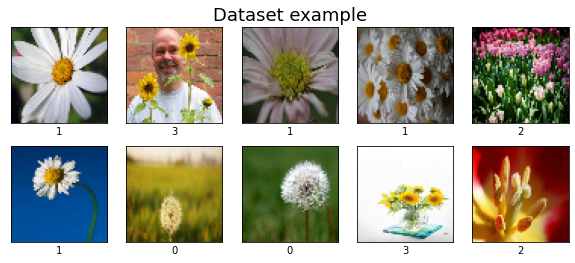

0:Dandelion 1:Daisy 2:Tulips 3:Sunflowers 4:Roses

        Train Info
학습시간 : 31.6초
학습 epoch :  2000
dropout rate :  0.3

           Train Loss
epoch : 100	loss : 1.5884599685668945
epoch : 200	loss : 1.4246400594711304
epoch : 300	loss : 1.023900032043457
epoch : 400	loss : 1.0698299407958984
epoch : 500	loss : 0.7831900119781494
epoch : 600	loss : 0.7352200150489807
epoch : 700	loss : 0.4119499921798706
epoch : 800	loss : 0.3237200081348419
epoch : 900	loss : 0.22440999746322632
epoch : 1000	loss : 0.4072999954223633
epoch : 1100	loss : 0.16252000629901886
epoch : 1200	loss : 0.17042000591754913
epoch : 1300	loss : 0.21852000057697296
epoch : 1400	loss : 0.14363999664783478
epoch : 1500	loss : 0.1543699949979782
epoch : 1600	loss : 0.02628999948501587
epoch : 1700	loss : 0.051330000162124634
epoch : 1800	loss : 0.0764399990439415
epoch : 1900	loss : 0.08172000199556351
epoch : 2000	loss : 0.061769999563694


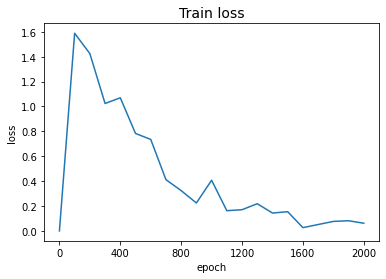


           Train Accuracy
epoch : 100	accuracy : 21.875%
epoch : 200	accuracy : 40.625%
epoch : 300	accuracy : 56.25%
epoch : 400	accuracy : 56.25%
epoch : 500	accuracy : 65.625%
epoch : 600	accuracy : 71.875%
epoch : 700	accuracy : 90.625%
epoch : 800	accuracy : 84.375%
epoch : 900	accuracy : 90.625%
epoch : 1000	accuracy : 87.5%
epoch : 1100	accuracy : 96.875%
epoch : 1200	accuracy : 90.625%
epoch : 1300	accuracy : 90.625%
epoch : 1400	accuracy : 93.75%
epoch : 1500	accuracy : 96.875%
epoch : 1600	accuracy : 96.875%
epoch : 1700	accuracy : 93.75%
epoch : 1800	accuracy : 100.0%
epoch : 1900	accuracy : 96.875%
epoch : 2000	accuracy : 96.875%


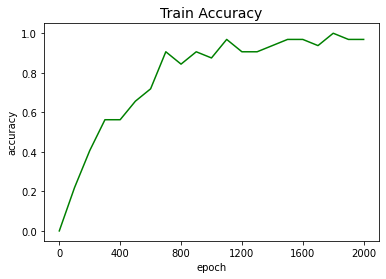


              Validation
Validation Loss : 2.0547800064086914
Validation Accuracy : 61.64383%


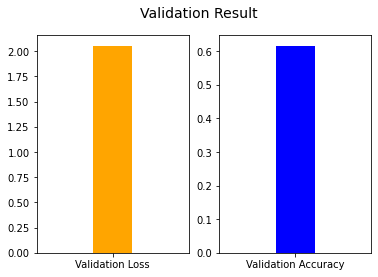


              test
test Loss : 1.738919973373413
test Accuracy : 65.69445%


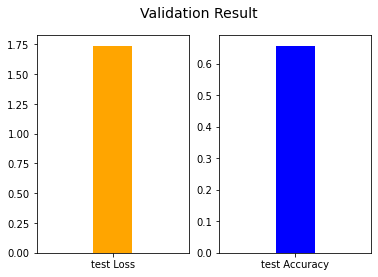

In [21]:
# SAVER_DIR="model"
# saver=tf.train.Saver()
# checkpoint_path=os.path.join(SAVER_DIR, "model")
# ckpt=tf.train.get_checkpoint_state(SAVER_DIR)

#-----------------------세션을 열고 학습 진행
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
            
    train_image_array, train_label_array, validation_image_array, validation_label_array, test_image_array, test_label_array =preprocess()
    plt_train_accuracy=[0]
    plt_train_loss=[0]
    plt_index=[0]
    start=time.time()
    
    print("\n=================================")
    print("          학습 진행 상황")
    print("=================================")
    
    for i in tqdm(range(train_epoch)):
        batch=next_batch(32, train_image_array, train_label_array)
        
        if (i+1)%100 == 0:
            # saver.save(sess, checkpoint_path, global_step=i+1)
            train_accuracy=accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
            train_loss=loss.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
            plt_train_accuracy.append(train_accuracy)
            plt_train_loss.append(train_loss)
            plt_index.append(i+1)


        sess.run(train_step, feed_dict={x: batch[0], y: batch[1], keep_prob: dropout_rate})

    train_time=time.time()-start
    validation_batch=next_batch(730, validation_image_array, validation_label_array)
    validation_loss=sess.run(loss, feed_dict={x: validation_batch[0], y: validation_batch[1], keep_prob: 1.0})
    validation_accuracy=sess.run(accuracy, feed_dict={x: validation_batch[0], y: validation_batch[1], keep_prob: 1.0})

    test_batch=next_batch(720, test_image_array, test_label_array)
    test_loss=sess.run(loss, feed_dict={x: test_batch[0], y: test_batch[1], keep_prob: 1.0})
    test_accuracy=sess.run(accuracy, feed_dict={x: test_batch[0], y: test_batch[1], keep_prob: 1.0})    

    
visualization()